<a href="https://colab.research.google.com/github/Viktor-Sok/Bioinformatics/blob/main/feed_forward_neural_network_in_PyTorch/NN_Torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install RDKit. Takes 2-3 minutes
%%capture
!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!time bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge python=3.7
!time conda install -q -y -c conda-forge rdkit=2020.09.02


In [ ]:
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')
from rdkit import Chem
from rdkit.Chem import Draw, AllChem
from rdkit import DataStructs
from sklearn.model_selection import train_test_split #splits data into the training and testing dataset
from sklearn.preprocessing import StandardScaler #standardize features by removing the mean and scaling to unit variance
from sklearn.feature_selection import VarianceThreshold #feature selector that removes all low-variance features.
import torch #machine learning framework
import torch.nn as nn #base class for all neural network modules.
from torch.optim import Adam # first-order gradient-based optimization of stochastic objective functions
from torch.utils.data import TensorDataset, DataLoader #Dataset wrapping tensors #
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np






In [ ]:
data = pd.read_csv('https://raw.githubusercontent.com/Viktor-Sok/Bioiformatics/main/feed_forward_neural_network_in_PyTorch/mol_data.csv')

In [ ]:
data.head()

,Ambit_InchiKey,Original_Entry_ID,Entrez_ID,Activity_Flag,pXC50,DB,Original_Assay_ID,Tax_ID,Gene_Symbol,Ortholog_Group,SMILES
0,AZMKBJHIXZCVNL-BXKDBHETNA-N,44590643,6532,A,5.68382,pubchem,393260,9606,SLC6A4,4061,FC1=CC([C@@H]2O[C@H](CC2)CN)=C(OC)C=C1
1,AZMKBJHIXZCVNL-UHFFFAOYNA-N,11492305,6532,A,5.16210,pubchem,393258,9606,SLC6A4,4061,FC1=CC(C2OC(CC2)CN)=C(OC)C=C1
2,AZOHUEDNMOIDOC-GETDIYNLNA-N,44419340,6532,A,6.66354,pubchem,276059,9606,SLC6A4,4061,FC1=CC=C(C[C@H]2C[C@@H](N(CC2)CC=C)CCCNC(=O)NC...
3,AZSKJKSQZWHDOK-VJSLDGLSNA-N,CHEMBL1080745,6532,A,6.96000,chembl20,617082,9606,SLC6A4,4061,C=1C=C(C=CC1)C2=CC(=C(N2CC(C)C)C)C(NCCCN3CCN(C...
4,AZTPZTRJVCAAMX-UHFFFAOYNA-N,CHEMBL578346,6532,A,8.00000,chembl20,596934,9606,SLC6A4,4061,C1=CC=C2C(=C1)C=C(C(N(C3CCNCC3)C4CCC4)=O)C=C2


(7228, 11)

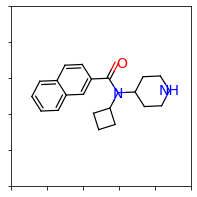

In [ ]:
# Example of conversion SNILE string to RDKit molecule object
mol = Chem.MolFromSmiles(data.SMILES[4])
Draw.MolToMPL(mol, size= (100,100) )
data.shape

In [ ]:
mol_objects = []
for element in data.SMILES:  # creates list of RDKit molecule objects from "SIMILES" column of the data frame
    temp_obj = Chem.MolFromSmiles(element)
    if temp_obj is None : continue # just in case for errors in SMILES strings
    mol_objects.append(temp_obj)
if (len(mol_objects) == len(data.SMILES)): # checking for converting errors
    print("No errors")

No errors


In [ ]:
def mol2fingerprint(mol): 
    #Gives Morrgan fingerprints for a molecule
    fingerprint = AllChem.GetHashedMorganFingerprint(mol, 2, nBits=4096 )
    array = np.zeros((1,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fingerprint, array)
    return array  


In [ ]:
fp_list = [] # list of fingerprints for all the molecules in the dataset
for mol in mol_objects:
  temp = mol2fingerprint(mol)
  fp_list.append(temp)

X = np.stack(fp_list) #coverts list of 1D numpy arrays to multidimensional numpy array   
np.shape(X)

(7228, 4096)

## Splitting data into the training (85%), validation (5%), and testing (10%) dataset  using sklearn





In [ ]:
#fingerprintes in X are the features for the model
#pXC50 values are the labels for the model
y = data.pXC50.values.reshape((-1,1))
X_train, X_test, y_train, y_test = train_test_split( X,y,  test_size=0.10, random_state=42) # creates testing dataset 
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train,  test_size=0.05, random_state=42) # creates train and validation datasets
X_train.shape

(6179, 4096)

##Scaling and centering labels

In [ ]:
#before scaling
pd.DataFrame(y_train).hist(bins=50) 


NameError: ignored

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa8f8757b10>]],
      dtype=object)

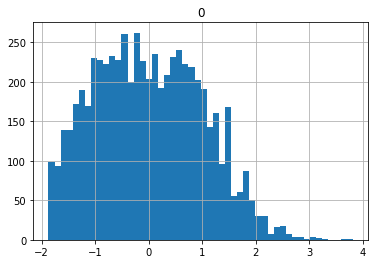

In [ ]:
#after scaling
scaler = StandardScaler() 
scaler.fit(y_train) # gives mean and std of labels
y_train = scaler.transform(y_train)
pd.DataFrame(y_train).hist(bins=50)

In [ ]:
# applying scaling for the testing and validation dataset using mean and std from the training dataset
y_test = scaler.transform(y_test)
y_validation = scaler.transform(y_validation)

##Removing low variance features defind by threshold hyper-parameter

In [ ]:
#Remoning because they can be almost always on, or very seldom used
#Basically  values which close to each other in the Morrgan fingerprints will be deleted
#Closeness is defined by threshold hyper-parameter
feature_select = VarianceThreshold(threshold=0.05)
X_train = feature_select.fit_transform(X_train)
X_validation = feature_select.transform(X_validation)
X_test = feature_select.transform(X_test)
X_train.shape

(6179, 221)

##Preparing dataset in the PyTorch

In [ ]:
#choosing GPU on which a torch.Tensor will be allocated if available
# structure of PyTorch tensors are different if they created for GPU or CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
#creating tensors
X_train = torch.tensor(X_train, device=device).float()
X_test = torch.tensor(X_test, device=device).float()
X_validation = torch.tensor(X_validation, device=device).float()
y_train = torch.tensor(y_train, device=device).float()
y_test = torch.tensor(y_test, device=device).float()
y_validation = torch.tensor(y_validation, device=device).float()


In [ ]:
#combining features and labels
train_dataset = TensorDataset(X_train, y_train)
validation_dataset = TensorDataset(X_validation, y_validation)
#defining batches and shuffling after each epochs
train_loader = DataLoader(dataset=train_dataset, batch_size=25, shuffle=True)
validation_loader = DataLoader(dataset=validation_dataset, batch_size=256, shuffle=False)

##Defining the structure of the network

In [ ]:
#creating subclass of nn.Module in which NN is defined
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate, out_size):
        super(Net, self).__init__()
        # Three layers and a output layer
        self.fc1 = nn.Linear(input_size, hidden_size)  
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc_out = nn.Linear(hidden_size, out_size) # Output layer
        #Layer normalization for faster training
        self.ln1 = nn.LayerNorm(hidden_size)
        self.ln2 = nn.LayerNorm(hidden_size)
        self.ln3 = nn.LayerNorm(hidden_size)        
        #LeakyReLU will be used as the activation function
        self.activation = nn.LeakyReLU()
        #Dropout for regularization
        self.dropout = nn.Dropout(dropout_rate)
     
    def forward(self, x):# Stacking each layer together
        out = self.fc1(x)
        out = self.ln1(out)
        out = self.activation(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.ln2(out)
        out = self.activation(out)
        out = self.dropout(out)
        out = self.fc3(out)
        out = self.ln3(out)
        out = self.activation(out)
        out = self.dropout(out)
        #Final output layer
        out = self.fc_out(out)
        return out

##Defining hyper-parameters of NN and creating the model

In [ ]:
#Defining the hyperparameters
input_size = X_train.size()[-1]     # The input size 
hidden_size = 1024   # The size of the hidden layer
dropout_rate = 0.80    # The dropout rate
output_size = 1        
learning_rate = 0.001  # The learning rate for the optimizer
model = Net(input_size, hidden_size, dropout_rate, output_size) #creating the model


In [ ]:
model.cuda() #The model can be moved to the GPU

Net(
  (fc1): Linear(in_features=221, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=1024, bias=True)
  (fc_out): Linear(in_features=1024, out_features=1, bias=True)
  (ln1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (ln2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (ln3): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (activation): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.8, inplace=False)
)

In [ ]:
criterion = nn.MSELoss() # loss function is the mean squared error
optimizer = Adam(model.parameters(), lr=learning_rate) # optimizer

##Training the model

In [ ]:
model.train() #Ensure the network is in "train" mode with dropouts active
epochs = 200 # number of times the whole dataset will be fed to the model
for e in range(epochs):
    running_loss = 0 #
    for fps, labels in train_loader:
        # Training pass
        optimizer.zero_grad() # Initialize the gradients, which will be recorded during the forward pa
         
        output = model(fps) #Forward pass of the mini-batch
        loss = criterion(output, labels) #Computing the loss
        loss.backward() # calculate the backward pass
        optimizer.step() # Optimize the weights
         
        running_loss += loss.item()
    else:
        if e%10 == 0:
            validation_loss = torch.mean(( y_validation - model(X_validation) )**2).item()
            print("Epoch: %3i Training loss: %0.2F Validation loss: %0.2F"%(e,(running_loss/len(train_loader)), validation_loss))

Epoch:   0 Training loss: 1.02 Validation loss: 0.75
Epoch:  10 Training loss: 0.50 Validation loss: 0.54
Epoch:  20 Training loss: 0.43 Validation loss: 0.52
Epoch:  30 Training loss: 0.38 Validation loss: 0.49
Epoch:  40 Training loss: 0.35 Validation loss: 0.52
Epoch:  50 Training loss: 0.32 Validation loss: 0.45
Epoch:  60 Training loss: 0.30 Validation loss: 0.42
Epoch:  70 Training loss: 0.30 Validation loss: 0.43
Epoch:  80 Training loss: 0.27 Validation loss: 0.42
Epoch:  90 Training loss: 0.26 Validation loss: 0.43
Epoch: 100 Training loss: 0.25 Validation loss: 0.38
Epoch: 110 Training loss: 0.25 Validation loss: 0.42
Epoch: 120 Training loss: 0.24 Validation loss: 0.37
Epoch: 130 Training loss: 0.23 Validation loss: 0.41
Epoch: 140 Training loss: 0.24 Validation loss: 0.43
Epoch: 150 Training loss: 0.23 Validation loss: 0.40
Epoch: 160 Training loss: 0.22 Validation loss: 0.43
Epoch: 170 Training loss: 0.22 Validation loss: 0.39
Epoch: 180 Training loss: 0.22 Validation loss

In [ ]:
PATH ="/tmp/state_dict_model.pt"
torch.save(model.state_dict(),PATH ) # saves model weights  after training in the state_dict

##Using model for predictions

In [ ]:
# load model weights stored in the state_dict
# we load model which was trained in GPU, but we want to make predictions on CPU
# Syntax to load :
# PATH ="/tmp/state_dict_model.pt" # path to the saved state_dict file
# device = torch.device('cpu')
# model_name = TheModelClass(*args, **kwargs)
# model_name.load_state_dict(torch.load(PATH, map_location=device))
#======================================================================#
device1 = torch.device('cpu')
PATH ="/tmp/state_dict_model.pt"
# hyperparameters for amodel (*args)
input_size = X_train.size()[-1]     # The input size 
hidden_size = 1024   # The size of the hidden layer
dropout_rate = 0.80    # The dropout rate
output_size = 1    
loaded_model = Net(input_size, hidden_size, dropout_rate, output_size)
loaded_model.load_state_dict(torch.load(PATH, map_location = device1))
loaded_model.eval() #Swith to evaluation mode, where dropout is switched off
for param_tensor in loaded_model.state_dict(): # print the state_dict
    print(param_tensor, "\t", loaded_model.state_dict()[param_tensor].size())

fc1.weight 	 torch.Size([1024, 221])
fc1.bias 	 torch.Size([1024])
fc2.weight 	 torch.Size([1024, 1024])
fc2.bias 	 torch.Size([1024])
fc3.weight 	 torch.Size([1024, 1024])
fc3.bias 	 torch.Size([1024])
fc_out.weight 	 torch.Size([1, 1024])
fc_out.bias 	 torch.Size([1])
ln1.weight 	 torch.Size([1024])
ln1.bias 	 torch.Size([1024])
ln2.weight 	 torch.Size([1024])
ln2.bias 	 torch.Size([1024])
ln3.weight 	 torch.Size([1024])
ln3.bias 	 torch.Size([1024])


In [ ]:
#loaded_model.cuda() #moves loaded_model to the GPU

Net(
  (fc1): Linear(in_features=221, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=1024, bias=True)
  (fc_out): Linear(in_features=1024, out_features=1, bias=True)
  (ln1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (ln2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (ln3): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (activation): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.8, inplace=False)
)

In [ ]:
# predicting for the training set, validation set and the  test set.
y_pred_train = loaded_model(X_train)
y_pred_validation = loaded_model(X_validation)
y_pred_test = loaded_model(X_test)

##Analysis of prediction accuracy

In [ ]:
# Calculating the root mean square error
# .item() method returns the value of this tensor as a standard Python number
# This only works for tensors with one element. For other cases, see tolist()
torch.mean(( y_train - y_pred_train )**2).item() #for the training data

0.1231372207403183

In [ ]:
torch.mean(( y_validation - y_pred_validation )**2).item() #for the validation data

0.322846382856369

In [ ]:
torch.mean(( y_test - y_pred_test )**2).item() #for the test dataset

0.30101898312568665

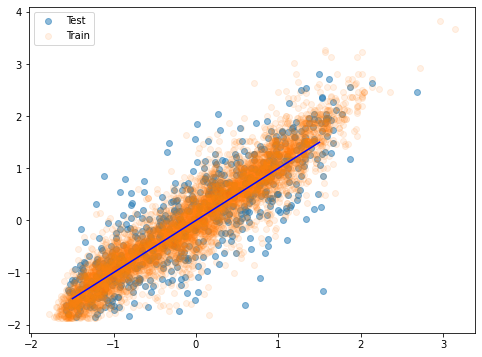

In [ ]:
def flatten(tensor):
    #detachs tensor from gradient, converts it to numpy and flatten it
    return tensor.detach().numpy().flatten()
plt.figure(figsize=(8, 6))
plt.scatter(flatten(y_pred_test), flatten(y_test), alpha=0.5, label="Test")
plt.scatter(flatten(y_pred_train), flatten(y_train), alpha=0.1, label="Train")
plt.legend()
plt.plot([-1.5, 1.5], [-1.5,1.5], c="b")

#Predicting an arbitrary molecule using the model

In [ ]:
data[["SMILES","pXC50" ]].head(5) # choose any smile string for prediction

,SMILES,pXC50
0,FC1=CC([C@@H]2O[C@H](CC2)CN)=C(OC)C=C1,5.68382
1,FC1=CC(C2OC(CC2)CN)=C(OC)C=C1,5.16210
2,FC1=CC=C(C[C@H]2C[C@@H](N(CC2)CC=C)CCCNC(=O)NC...,6.66354
3,C=1C=C(C=CC1)C2=CC(=C(N2CC(C)C)C)C(NCCCN3CCN(C...,6.96000
4,C1=CC=C2C(=C1)C=C(C(N(C3CCNCC3)C4CCC4)=O)C=C2,8.00000


In [ ]:
def predict_smiles(smiles):
    fp =mol2fingerprint( Chem.MolFromSmiles(smiles) ).reshape(1,-1) # creates Morgan fingerprint
    fp_filtered = feature_select.transform(fp) # use the VarianceThreshold object on the fingerprints
    fp_tensor = torch.tensor(fp_filtered, device=device1).float() # creates PyTorch tensor for a partiicular device
    prediction = loaded_model(fp_tensor) # prediction
    pXC50 = scaler.inverse_transform(prediction.cpu().detach().numpy())# scaling back prediction
    return pXC50[0][0]
predict_smiles('C1=CC=C2C(=C1)C=C(C(N(C3CCNCC3)C4CCC4)=O)C=C2')


7.9737267